In [35]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [36]:
# 匯入資料，把csv檔(連結下方)放到與程式檔同一資料夾
df = pd.read_csv('file.csv',parse_dates=['Date'],index_col=0).dropna()
df = df[(df.index > '2018-06-01')]
df_plot = df[['Open','High','Low','Close']]

In [37]:
#計算MA線
def moving_average(data,period):
    return data['Close'].rolling(period).mean()


In [38]:
#計算KD線
'''
Step1:計算RSV:(今日收盤價-最近9天的最低價)/(最近9天的最高價-最近9天的最低價)
Step2:計算K: K = 2/3 X (昨日K值) + 1/3 X (今日RSV)
Step3:計算D: D = 2/3 X (昨日D值) + 1/3 X (今日K值)
'''
def KD(data):
    data_df = data.copy()
    data_df['min'] = data_df['Low'].rolling(9).min()
    data_df['max'] = data_df['High'].rolling(9).max()
    data_df['RSV'] = (data_df['Close'] - data_df['min'])/(data_df['max'] - data_df['min'])
    data_df = data_df.dropna()
    # 計算K
    # K的初始值定為50
    K_list = [50]
    for num,rsv in enumerate(list(data_df['RSV'])):
        K_yestarday = K_list[num]
        K_today = 2/3 * K_yestarday + 1/3 * rsv
        K_list.append(K_today)
    data_df['K'] = K_list[1:]
    # 計算D
    # D的初始值定為50
    D_list = [50]
    for num,K in enumerate(list(data_df['K'])):
        D_yestarday = D_list[num]
        D_today = 2/3 * D_yestarday + 1/3 * K
        D_list.append(D_today)
    data_df['D'] = D_list[1:]
    use_df = pd.merge(data,data_df[['K','D']],left_index=True,right_index=True,how='left')
    return use_df
        

In [39]:
df = KD(df)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,K,D
Date,,,,,,,,
2019-01-24,222.5,222.5,220.5,222.5,222.5,26417924.0,0.844688,0.804560
2019-01-25,226.5,227.0,225.0,226.0,226.0,46692764.0,0.867473,0.825531
2019-01-28,229.5,229.5,228.0,229.0,229.0,26026257.0,0.897760,0.849607
2019-01-29,222.5,225.0,222.0,222.5,222.5,41122520.0,0.737395,0.812203
2019-01-30,220.5,221.5,220.0,221.0,221.0,44755945.0,0.588819,0.737742


In [46]:
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter
import datetime as dt

In [41]:
def prepare_data(data):
    data_df = data.copy()
    data_df['DateTime'] = data_df.index
    data_df = data_df.reset_index()
    data_df = data_df[['DateTime','Open','High','Low','Close']]
    data_df['DateTime'] = mdates.date2num(data_df['DateTime'].astype(dt.date))
    return data_df

In [94]:
# 畫股價圖
# 顏色:https://matplotlib.org/users/colors.html

#畫股價線圖與蠟燭圖
def plot_stock_price(data):
    Ma_10 = moving_average(data,10)
    Ma_50 = moving_average(data,50)
    Length = len(data['DateTime'].values[50-1:])
    fig = plt.figure(facecolor='white',figsize=(15,10))
    ax1 = plt.subplot2grid((6,4), (0,0),rowspan=4, colspan=4, facecolor='w')
    candlestick_ohlc(ax1, data.values[-Length:],width=0.6,colorup='red',colordown='green')
    Label1 = '10 MA Line'
    Label2 = '50 MA Line'
    ax1.plot(data.DateTime.values[-Length:],Ma_10[-Length:],'black',label=Label1, linewidth=1.5)
    ax1.plot(data.DateTime.values[-Length:],Ma_50[-Length:],'navy',label=Label2, linewidth=1.5)
    ax1.legend(loc='upper center', ncol=2)
    ax1.grid(True, color='black')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.yaxis.label.set_color("black")
    plt.ylabel('Stock price and Volume')
    plt.suptitle('Stock Code:2330',color='black',fontsize=16)
    #畫交易量
    ax1v = ax1.twinx()
    ax1v.fill_between(data.DateTime.values[-Length:],0, df.Volume.values[-Length:], facecolor='navy', alpha=.4)
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.grid(False)
    ax1v.set_ylim(0, 3*df.Volume.values.max())
    #加入KD線在下方
    ax2 = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4, facecolor='white')
    ax2.plot(daysreshape.DateTime.values[-Length:], df.K[-Length:],color='black')
    ax2.plot(daysreshape.DateTime.values[-Length:], df.D[-Length:],color='navy')
    plt.ylabel('KD Value', color='black')
    


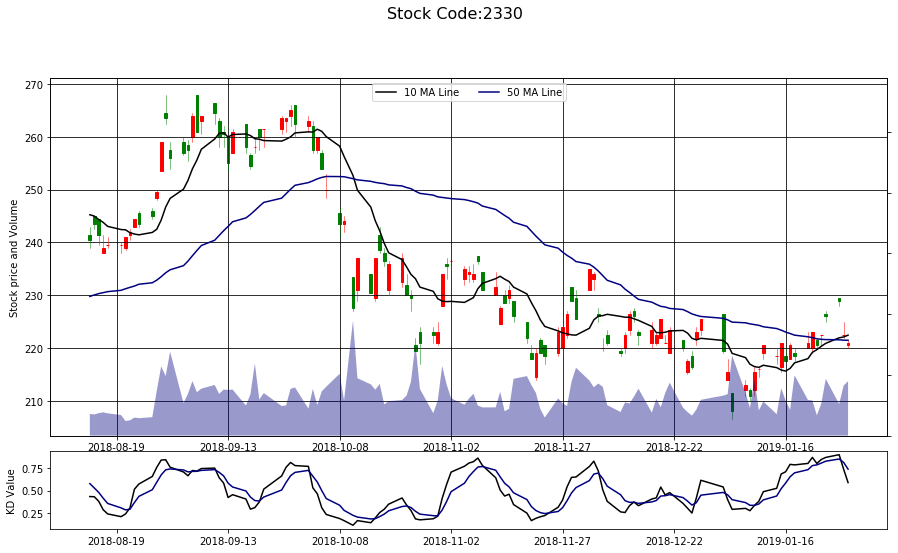

In [95]:
daysreshape = prepare_data(df_plot)
plot_stock_price(daysreshape)
plt.show()